# Diversity Analysis
In this notebook we will explore some diversity aspect of the generated ligands. This includes
* Murcko scaffold analysis
* Tanimoto similarity

In [35]:
import copy
import math
from collections import defaultdict
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns
import utils_eval
from IPython.core.display import HTML
from kinfraglib import utils
from PIL import Image as pilImage
from rdkit import Chem, DataStructs, Geometry
from rdkit.Chem import AllChem, Draw, PandasTools, rdFingerprintGenerator
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D

PandasTools.RenderImagesInAllDataFrames(images=True)

## Load and prepare ligands
Load generated ligands, compute the mean binding affinity (HYDE score), and put the fragment IDs into a python dictionary

In [36]:
# read data
data = utils_eval.read_mols('../results_5n1f_25_02/5n1f/results.sdf')
data['binding_affinity'] = data.apply(lambda x: (x['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM]'] + x['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM]'])/2, axis=1)
data = data[data['binding_affinity'] <= 1000].copy().reset_index(drop=True)
data['inchi'] = data.apply(lambda x: Chem.MolToInchi(utils.standardize_mol(x.ROMol)), axis=1)

,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,BIOSOLVEIT.DOCKING_SCORE,filtered,num_fragments,binding_affinity,inchi,AP,AP_smiles,SE,SE_smiles,FP,FP_smiles,GA,GA_smiles
0,,0.016451,1.634481,4.27248,387.528,81.73,"{'AP': 136, 'FP': 8}",CC(C)(C)c1ccc(CC2(N)CCN(c3ccnc4[nH]cc(C#N)c34)...,"{'AP': 'N#Cc1c[nH]c2ncccc12', 'FP': '[44*]N1CC...","{'AP': '[4*]c1ccnc2[nH]cc(C#N)c12', 'FP': 'CC(...",133.57,1,2,0.825466,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",136,N#Cc1c[nH]c2ncccc12,None,None,8,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,None
1,,0.034646,3.442295,3.87210,393.939,54.42,"{'AP': 420, 'FP': 7}",CCNc1nccc(-c2ccc(C3(c4ccc(Cl)cc4)CC[NH2+]CC3)c...,"{'AP': 'CCNc1ncccn1', 'FP': '[37*]c1ccc(C2(c3c...","{'AP': '[16*]c1ccnc(N[C@H]([56*])C)n1', 'FP': ...",67.60,1,2,1.738471,InChI=1S/C23H25ClN4/c1-2-26-22-27-14-11-21(28-...,420,CCNc1ncccn1,None,None,7,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,None
2,,0.044649,4.436102,4.57500,424.353,58.18,"{'AP': 8, 'FP': 7}",Clc1ccc(C2(c3ccc(-c4ncnc5[nH]cc(Cl)c45)cc3)CC[...,"{'AP': 'Clc1c[nH]c2ncncc12', 'FP': '[37*]c1ccc...","{'AP': '[17*]c1ncnc2[nH]cc(Cl)c12', 'FP': 'Clc...",29.01,1,2,2.240375,InChI=1S/C23H20Cl2N4/c24-18-7-5-17(6-8-18)23(9...,8,Clc1c[nH]c2ncncc12,None,None,7,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,None
3,,0.058308,5.793213,1.53970,337.381,88.91,"{'AP': 327, 'FP': 348}",CNc1cc2c(ccc(=O)n2CCC(=O)NCc2ccccn2)cn1,"{'AP': 'CNc1cc2[nH]c(=O)ccc2cn1', 'FP': '[20*]...","{'AP': '[22*]n1c(=O)c([41*])cc2cnc(NC)cc21', '...",124.80,1,2,2.925760,InChI=1S/C18H19N5O2/c1-19-16-10-15-13(11-21-16...,327,CNc1cc2[nH]c(=O)ccc2cn1,None,None,348,CCC(=O)NCc1ccccn1,NaN,None
4,,0.072138,7.167373,4.15510,372.941,68.17,"{'AP': 220, 'FP': 8}",CC(C)(C)c1ccc(CC2(N)CCN(c3cc(N)ncc3Cl)CC2)cc1,"{'AP': 'Nc1ccc(Cl)cn1', 'FP': '[44*]N1CCC([NH3...","{'AP': '[4*]Nc1cc([16*])c(Cl)cn1', 'FP': 'CC(C...",41.54,1,2,3.619756,"InChI=1S/C21H29ClN4/c1-20(2,3)16-6-4-15(5-7-16...",220,Nc1ccc(Cl)cn1,None,None,8,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,None

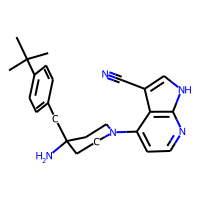
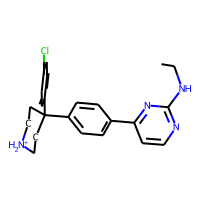
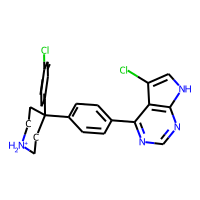
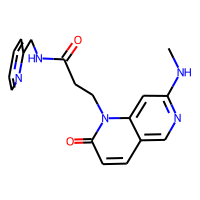
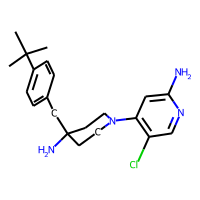

In [37]:
# convert fragment_ids
for sp in ['AP', 'SE', 'FP', 'GA']:
    data[sp] = data.apply(lambda x: x.fragment_ids.get(sp), axis=1)
    data[sp + '_smiles'] = data.apply(lambda x: (x.smiles_fragments_dummy.get(sp) if '*' in x.smiles_fragments.get(sp) else x.smiles_fragments.get(sp)) if x.smiles_fragments_dummy.get(sp) else None, axis=1)

HTML(data.head().to_html(notebook=True))

In [38]:
print(f"Duplicates: {sum(data.inchi.duplicated())}")

Duplicates: 30


## Murcko Similarity
A Murcko scaffold can be used to represent the core structure of a ligand. It is the union of all rings and linkers - between rings -  of a molecule, thus disregarding the side chains. Here, we will use these Murcko scaffolds to analyse the diversity of the generated ligands from a structural point of view. First, we will look at the quantities of the scaffolds. Next, we determine the most frequent scaffolds. Lastly, we *measure* the information-based entropy of the scaffold using the Shannon-Entropy.

In [39]:
# add murcko smiles 
PandasTools.AddMurckoToFrame(data)

In [40]:
scaffolds = data.groupby('Murcko_SMILES').size()
scaffolds = scaffolds.sort_values(ascending=False)
# apply scaffold ids
data['scaffold_id'] = data.apply(lambda x: scaffolds.index.get_loc(x.Murcko_SMILES), axis=1)

In [41]:
print(f"Number of unique scaffolds: {scaffolds.size}")

Number of unique scaffolds: 800


In [42]:
# determine the number of singletons
data['is_singleton'] = data.apply(lambda x: scaffolds[x.Murcko_SMILES] == 1, axis=1)
singletons = data[data['is_singleton']]

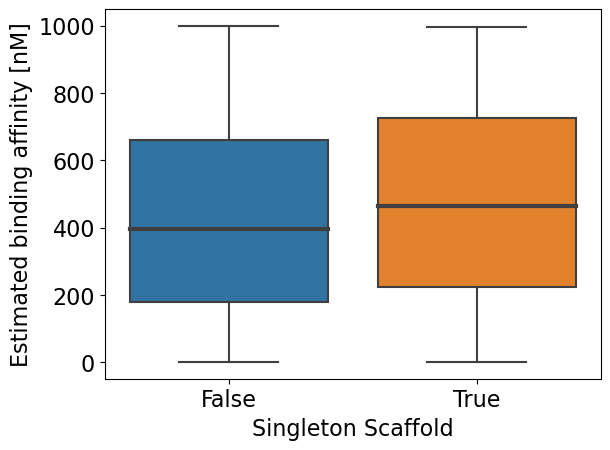

In [43]:
sns.boxplot(
    x = 'is_singleton',
    y='binding_affinity',
    data=data,
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Singleton Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [44]:
print(f"# singletons: {sum(scaffolds == 1)}")

# singletons: 598


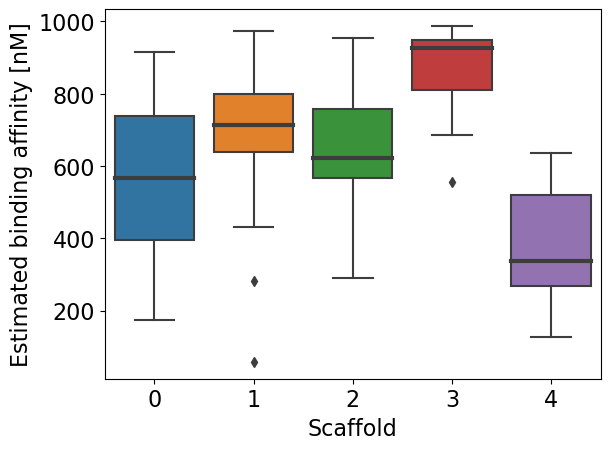

In [45]:
# plot binding affinity of top 5
sns.boxplot(
    x = 'scaffold_id',
    y='binding_affinity',
    data=data[data['scaffold_id'] < 5],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

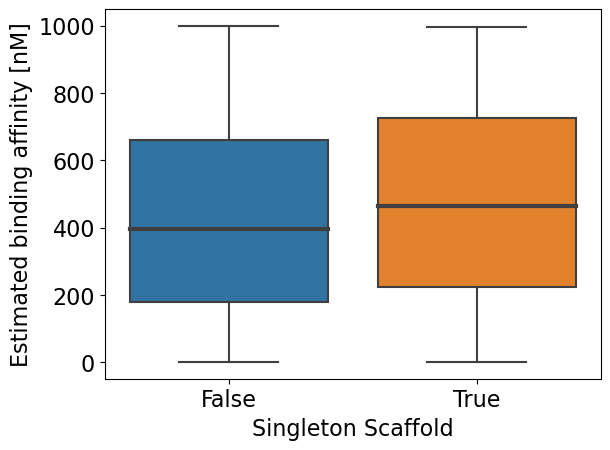

In [46]:
# plot binding affinity of top 5
sns.boxplot(
    x = 'is_singleton',
    y='binding_affinity',
    data=data,
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Singleton Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

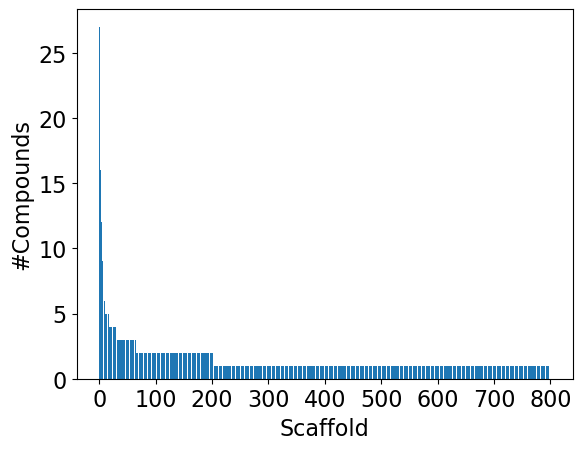

In [47]:
# plot top 15 scaffolds 
plt.bar(range(len(scaffolds)), scaffolds)
plt.ylabel('#Compounds', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [48]:
print(f"Scaffold 0: {scaffolds[0]} compounds => {scaffolds[0]/data.index.size * 100}%")

Scaffold 0: 27 compounds => 2.25752508361204%


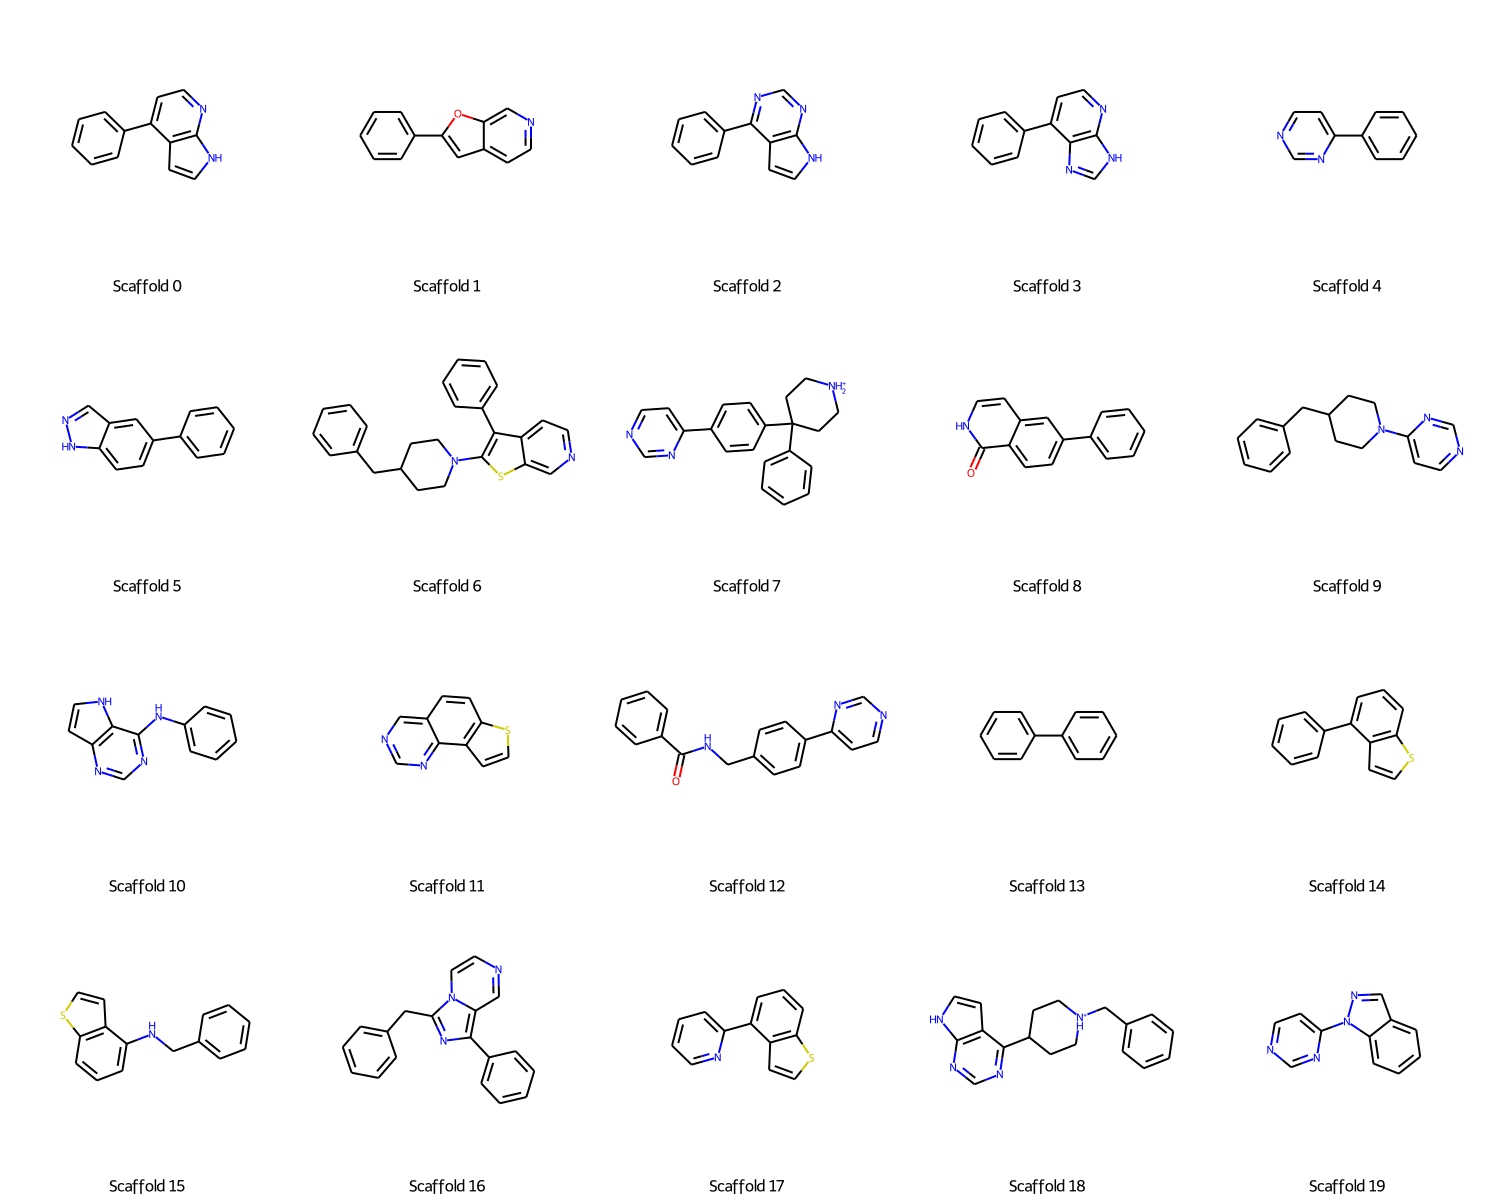

In [49]:
# print most common scaffolds
mols = [AllChem.MolFromSmiles(idx) for idx in scaffolds.index[:20]]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols, 
    legends=[
        f"Scaffold {i}" for i in range(20)
    ],  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)
img

In [50]:
# from adapted from https://greglandrum.github.io/rdkit-blog/posts/2021-08-07-rgd-and-highlighting.html
def highlight_scaffold(mol, patt, color, width=350,height=200,
                      fillRings=True,legend=""):
    # copy the molecule and core
    mol = Chem.Mol(mol)

    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps

  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    hit_ats = list(mol.GetSubstructMatch(patt))

    rings = []   
    rinfo = mol.GetRingInfo()
    for at_idx in list(mol.GetSubstructMatch(patt)):
        highlightatoms[at_idx].append(color)
        atomrads[at_idx] = 0.4
    if fillRings:
        for aring in rinfo.AtomRings():
            tring = []
            allFound = True
            for aid in aring:
                if aid in hit_ats:
                    tring.append(aid)
            if allFound:
                rings.append((tring,color))
    for qbnd in patt.GetBonds():
        batom = hit_ats[qbnd.GetBeginAtomIdx()]
        eatom = hit_ats[qbnd.GetEndAtomIdx()]
        bndIdx = mol.GetBondBetweenAtoms(batom,eatom).GetIdx()
        highlightbonds[bndIdx].append(color)
        widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()

    dos.legendFontSize = 65
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(mol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = mol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(mol,legend,dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    return png

def draw_multiple(ms,pattern,legends=None,nPerRow=5,subImageSize=(250,200)):
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    # colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    #colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(0,158,115),(86,180,233),(204,121,167),(0,114,178),(230,159,0),(213,94,0),(240,228,66)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)

    nRows = len(ms)//nPerRow
    if len(ms)%nPerRow:
        nRows+=1
    nCols = nPerRow
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize)
    
    for i,m in enumerate(ms):
        col = i%nPerRow
        row = i//nPerRow
        if legends:
            legend = legends[i]
        else:
            legend = ''
        png = highlight_scaffold(m,pattern[i],legend=legend,
                               width=subImageSize[0],height=subImageSize[1], color = colors[i//nPerRow])
        bio = BytesIO(png)
        img = pilImage.open(bio)
        res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
    bio = BytesIO()
    res.save(bio,format='PNG')
    return bio.getvalue()

In [51]:
mols = []
scaffolds_pattern =[]
legend = []
paint_bonds = []
paint_atoms = []
for i in range(5):
    scaffold_compounds = data[data['scaffold_id'] == i].copy()
    scaffold_compounds = scaffold_compounds.drop_duplicates(subset=['inchi'])
    _mols = [copy.deepcopy(mol) for mol in scaffold_compounds['ROMol'][:5]]
    for mol in _mols:
        rdDepictor.Compute2DCoords(mol)
    mols += _mols
    _patt = [AllChem.MolFromSmarts(smiles) for smiles in scaffold_compounds['Murcko_SMILES'][:5]]
    for mol in _patt:
        rdDepictor.Compute2DCoords(mol)
    for mol in _mols:
        rdDepictor.GenerateDepictionMatching2DStructure(mol, _patt[0])
    scaffolds_pattern += _patt
    legend += [f"Scaffold {i} compound" for _ in range(5)]

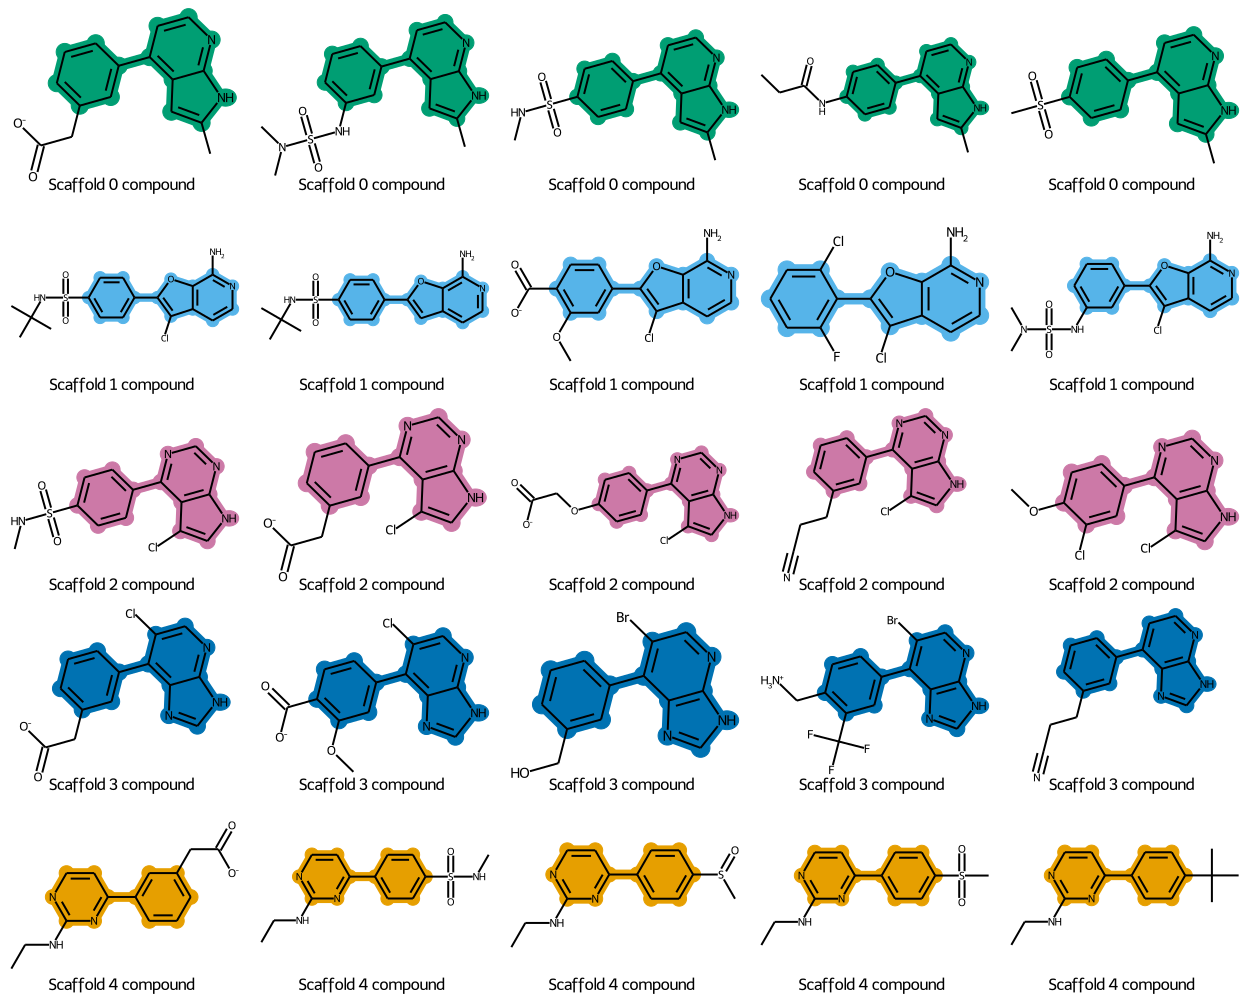

In [52]:
from IPython import display
display.Image(draw_multiple(mols, scaffolds_pattern, legends=legend))

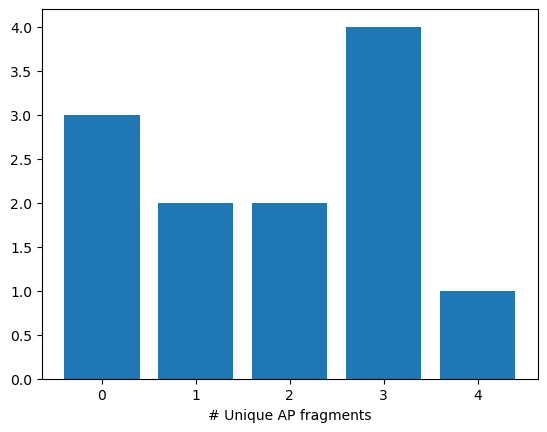

In [53]:
# unique AP fragments per scaffold
plt.bar(range(5), [data[data['scaffold_id'] == i]['AP'].unique().size for i in range(5)])
plt.xlabel("# Unique AP fragments")
plt.show()

Legend: Fragment id | Scaffold


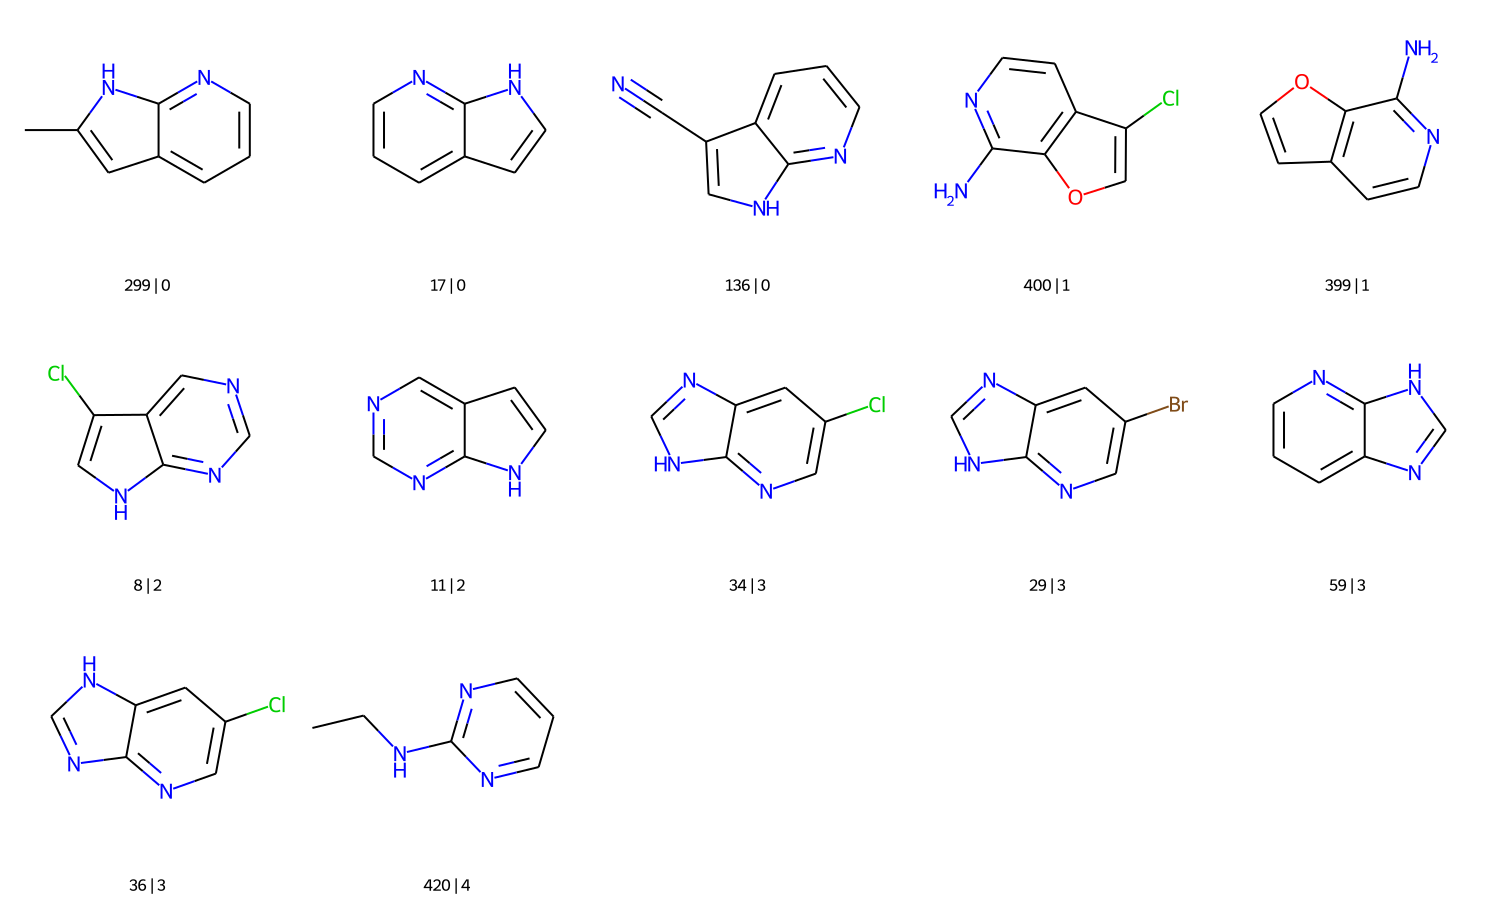

In [54]:
mols = []
legend = []
for i in range(5):
    scaffold_compounds = data[data['scaffold_id'] == i]
    mols += [AllChem.MolFromSmiles(mol) for mol in scaffold_compounds['AP_smiles'].unique()]
    legend += [f"{id} | {i}" for id in scaffold_compounds['AP'].unique()]
# print most common scaffolds
for mol in mols:
    AllChem.Compute2DCoords(mol)
print(f"Legend: Fragment id | Scaffold")
Draw.MolsToGridImage(
    mols, 
    legends=legend,  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)

### Shannon entropy
To *measure* the entropy of the $n$ distinct scaffolds, we calculate the Shannon Entropy 

$SE = \sum_{i=1}^np_ilog_2(p_i)$,

where $p_i$ is the frequency of scaffold $i$ in the set of generated ligands. The scaled SE

$SSE = \frac{SE}{log_2(n)}$

scales the $SE$ to a value between $0$ and $1$. A SSE near $1$ indicates a high entropy, while a value equal $0$ means, that all compounds have the same scaffold.

In [55]:
# Shannon entropy
P = data.index.size
se = - sum((scaffold / P) * math.log2(scaffold / P) for scaffold in scaffolds)
sse = se / math.log2(scaffolds.size)
print(f"SE: {se}\nSSE: {sse}")

SE: 9.279174320060456
SSE: 0.9621850572490973


## Tanimoto similarity
To analyse the fingerprint-based diversity of the dataset, we determine the RDKit (topological) fingerprints of all compounds and calculate the Tanimoto coefficient of all pairs of compound fingerprints.

In [56]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.append([1 - x for x in similarities])
    return dissimilarity_matrix

In [57]:
# generate fingerprints
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
data['rdkit_fingerprint'] = [rdkit_gen.GetFingerprint(Chem.MolFromInchi(ligand_inchi)) for ligand_inchi in data.inchi]

In [58]:
mean_sims = []
nearest_neighbor = []
all_similarities = []
for idx in data.index:
    similarities = DataStructs.BulkTanimotoSimilarity(data.rdkit_fingerprint[idx], data.rdkit_fingerprint)
    all_similarities.append(similarities.copy())
    similarities.remove(1) # self simimlarity
    mean_sims.append((sum(similarities)) / (len(similarities)))
    nearest_neighbor.append(max(similarities))
    
data['mean_tanimoto_sims'] = mean_sims
data['nearest_neighbor_sim'] = nearest_neighbor

,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,BIOSOLVEIT.DOCKING_SCORE,filtered,num_fragments,binding_affinity,inchi,AP,AP_smiles,SE,SE_smiles,FP,FP_smiles,GA,GA_smiles,Murcko_SMILES,scaffold_id,is_singleton,rdkit_fingerprint,mean_tanimoto_sims,nearest_neighbor_sim
432,,6.467281,642.562593,2.1343,274.714,70.59,"{'AP': 34, 'FP': 463}",CN(C)c1cc(-c2c(Cl)cnc3[nH]cnc23)cnn1,"{'AP': 'Clc1cnc2[nH]cnc2c1', 'FP': '[14*]c1cc(...","{'AP': '[9*]c1nc2c([26*])c(Cl)cnc2[nH]1', 'FP'...",136.52,1,2,324.514937,InChI=1S/C12H11ClN6/c1-19(2)9-3-7(4-17-18-9)10...,34,Clc1cnc2[nH]cnc2c1,None,None,463,CN(C)c1cccnn1,NaN,None,c1cc(-c2ccnc3[nH]cnc23)cnn1,21,False,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.217971,1.0
384,,5.746131,570.912042,2.1343,274.714,70.59,"{'AP': 36, 'FP': 463}",CN(C)c1cc(-c2c(Cl)cnc3[nH]cnc23)cnn1,"{'AP': 'Clc1cnc2nc[nH]c2c1', 'FP': '[14*]c1cc(...","{'AP': '[14*]c1c(Cl)cnc2nc([24*])[nH]c12', 'FP...",142.43,1,2,288.329087,InChI=1S/C12H11ClN6/c1-19(2)9-3-7(4-17-18-9)10...,36,Clc1cnc2nc[nH]c2c1,None,None,463,CN(C)c1cccnn1,NaN,None,c1cc(-c2ccnc3[nH]cnc23)cnn1,21,False,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.217971,1.0
1103,,19.137400,1901.413859,3.9403,294.140,50.80,"{'AP': 36, 'FP': 199}",COc1ccc(-c2c(Cl)cnc3[nH]cnc23)cc1Cl,"{'AP': 'Clc1cnc2nc[nH]c2c1', 'FP': '[11*]c1ccc...","{'AP': '[14*]c1c(Cl)cnc2nc([24*])[nH]c12', 'FP...",197.97,1,2,960.275630,InChI=1S/C13H9Cl2N3O/c1-19-10-3-2-7(4-8(10)14)...,36,Clc1cnc2nc[nH]c2c1,None,None,199,COc1ccccc1Cl,NaN,None,c1ccc(-c2ccnc3[nH]cnc23)cc1,3,False,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.215221,1.0
1126,,19.674407,1954.768675,3.9403,294.140,50.80,"{'AP': 34, 'FP': 199}",COc1ccc(-c2c(Cl)cnc3[nH]cnc23)cc1Cl,"{'AP': 'Clc1cnc2[nH]cnc2c1', 'FP': '[11*]c1ccc...","{'AP': '[9*]c1nc2c([26*])c(Cl)cnc2[nH]1', 'FP'...",197.50,1,2,987.221541,InChI=1S/C13H9Cl2N3O/c1-19-10-3-2-7(4-8(10)14)...,34,Clc1cnc2[nH]cnc2c1,None,None,199,COc1ccccc1Cl,NaN,None,c1ccc(-c2ccnc3[nH]cnc23)cc1,3,False,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.215221,1.0
1092,,18.869095,1874.756152,1.6504,302.696,90.93,"{'AP': 36, 'FP': 138}",COc1cc(-c2c(Cl)cnc3[nH]cnc23)ccc1C(=O)[O-],"{'AP': 'Clc1cnc2nc[nH]c2c1', 'FP': '[24*]c1ccc...","{'AP': '[14*]c1c(Cl)cnc2nc([24*])[nH]c12', 'FP...",136.38,1,2,946.812623,InChI=1S/C14H10ClN3O3/c1-21-10-4-7(2-3-8(10)14...,36,Clc1cnc2nc[nH]c2c1,None,None,138,COc1ccccc1C(=O)[O-],NaN,None,c1ccc(-c2ccnc3[nH]cnc23)cc1,3,False,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.231325,1.0

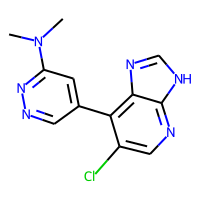
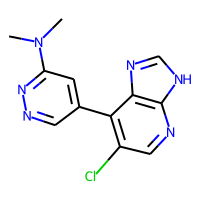
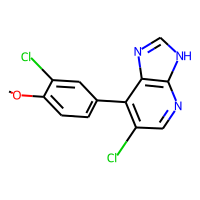
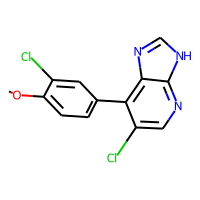
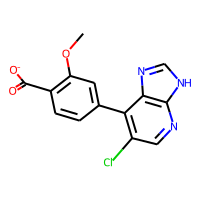

In [59]:
HTML(data[data['inchi'].duplicated(keep=False)].sort_values("inchi").head().to_html(notebook=True))

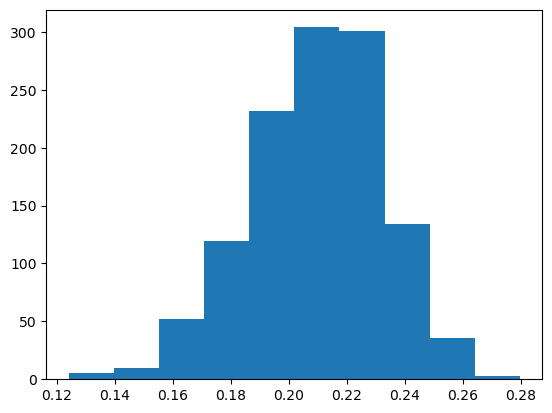

In [60]:
plt.hist(data['mean_tanimoto_sims'])
plt.show()

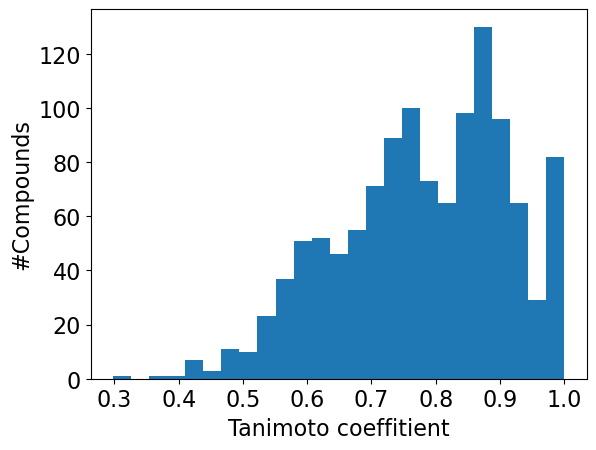

In [61]:
plt.hist(data['nearest_neighbor_sim'], bins=25)
plt.xlabel('Tanimoto coeffitient', fontsize=16)
plt.ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

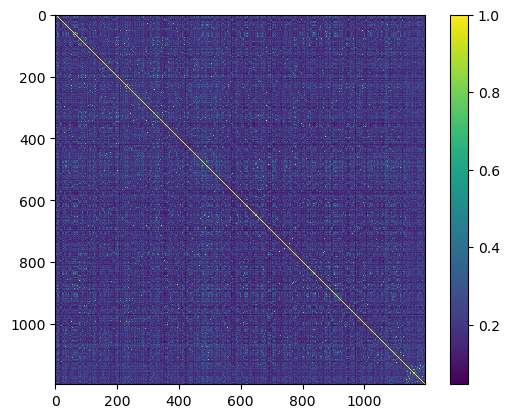

In [62]:
plt.imshow(all_similarities, interpolation='nearest')
plt.colorbar()
plt.show()

/home/katharina/miniforge3/envs/king_frag_lib_pocket_enum/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


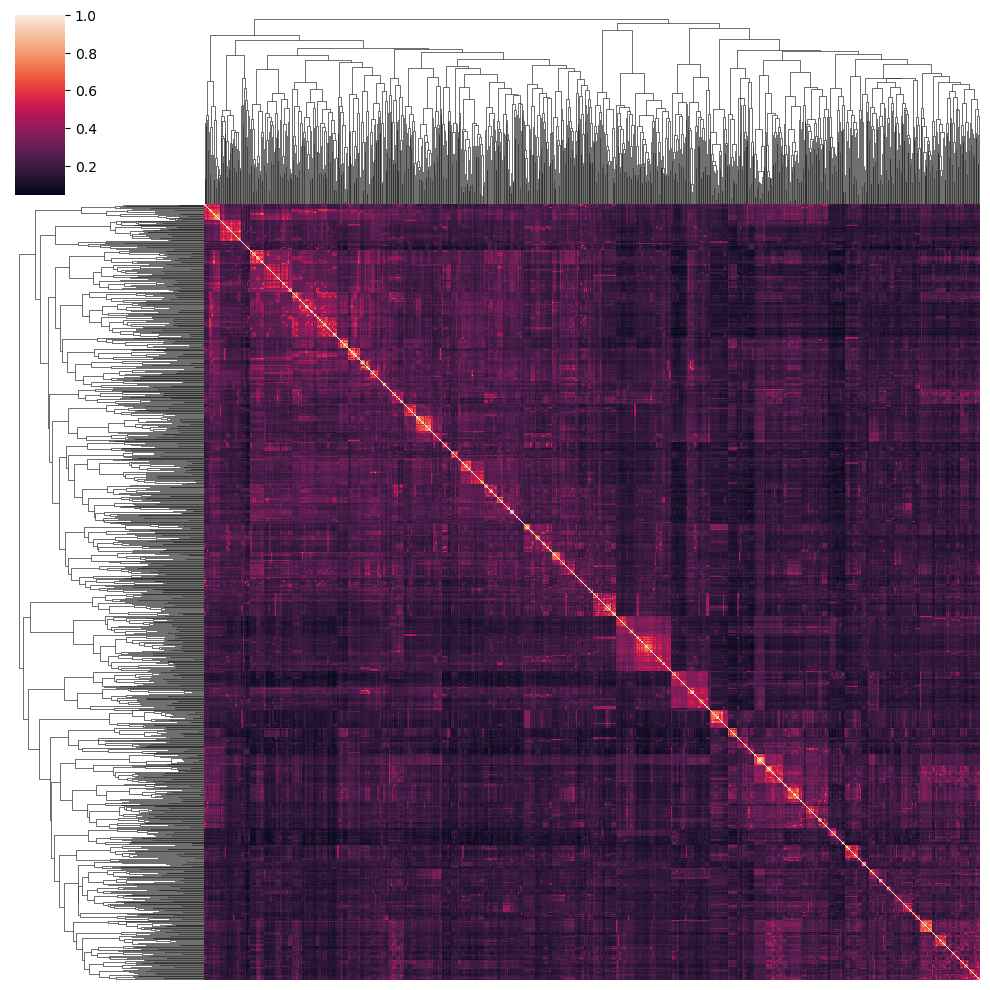

In [63]:
g = sns.clustermap(all_similarities, yticklabels=False,xticklabels=False)

In [64]:
print(f"Tanimoto mean similarity stats\n{data['mean_tanimoto_sims'].describe()}")

Tanimoto mean similarity stats
count    1196.000000
mean        0.209746
std         0.022558
min         0.124216
25%         0.195424
50%         0.211946
75%         0.225258
max         0.279680
Name: mean_tanimoto_sims, dtype: float64


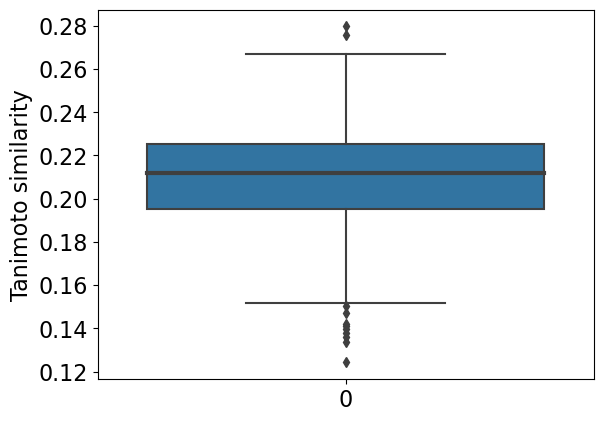

In [70]:
sns.boxplot(
    data['mean_tanimoto_sims'],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Tanimoto similarity', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()